In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, mutual_info_score, roc_auc_score
from sklearn.tree import DecisionTreeRegressor, export_text

%matplotlib inline

# Data preparation

In [2]:
remote_csv = 'wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

!wget $remote_csv -O data.csv

--2023-10-20 11:37:26--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘wget’
--2023-10-20 11:37:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2023-10-20 11:37:26 (12.7 MB/s) - ‘data.csv’ saved [1423529/1423529]

FINISHED --2023-10-20 11:37:26--
Total wall clock time: 0.2s
Downloaded: 1 files, 1.4M in 0.1s (12.7 MB/s)


In [3]:
orig_df = pd.read_csv('data.csv')
orig_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df_prep = orig_df[orig_df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df_prep = df_prep.reset_index(drop=True)

In [8]:
df_prep = df_prep.fillna(0)

df_prep.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [9]:
np.log1p(orig_df['median_house_value'])

0        13.022766
1        12.789687
2        12.771673
3        12.740520
4        12.743154
           ...    
20635    11.265758
20636    11.252872
20637    11.432810
20638    11.346883
20639    11.400887
Name: median_house_value, Length: 20640, dtype: float64

In [10]:
df_prep.median_house_value = np.log1p(orig_df['median_house_value'])

orig_df.median_house_value, df_prep.median_house_value

(0        452600.0
 1        358500.0
 2        352100.0
 3        341300.0
 4        342200.0
            ...   
 20635     78100.0
 20636     77100.0
 20637     92300.0
 20638     84700.0
 20639     89400.0
 Name: median_house_value, Length: 20640, dtype: float64,
 0        13.022766
 1        12.789687
 2        12.771673
 3        12.740520
 4        12.743154
            ...    
 15682    13.122365
 15683    13.122367
 15684    13.122367
 15685    13.122367
 15686    13.122367
 Name: median_house_value, Length: 15687, dtype: float64)

In [18]:
seed = 1

df_full_train, df_test = train_test_split(df_prep, test_size=0.2,random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.astype('int').values
y_val = df_val.median_house_value.astype('int').values
y_test = df_test.median_house_value.astype('int').values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

df_full_train.head(), df_train.head()

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 11580    -117.25     34.04                18.0       5761.0          1063.0   
 5151     -118.11     34.18                52.0       3571.0           510.0   
 1260     -124.10     40.50                42.0       2380.0           553.0   
 5329     -118.16     34.09                52.0       1722.0           448.0   
 2432     -118.45     34.20                18.0       2729.0           800.0   
 
        population  households  median_income  median_house_value  \
 11580      2763.0      1058.0         4.4472           12.296375   
 5151       1434.0       490.0         5.9009           11.491712   
 1260       1300.0       504.0         1.7574           12.150037   
 5329       1122.0       425.0         3.1204           12.923915   
 2432       2099.0       742.0         2.5842           11.442514   
 
       ocean_proximity  
 11580          INLAND  
 5151           INLAND  
 1260        <1H OCEAN  
 5

In [33]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Question 1

In [23]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(X_train, y_train)

model

DecisionTreeRegressor(max_depth=1, random_state=1)

In [26]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- latitude <= 34.05
|   |--- value: [11.76]
|--- latitude >  34.05
|   |--- value: [11.47]



# Question 2

In [53]:
def calculate_rmse(y, y_pred):
    err = y - y_pred
    sq_err = err ** 2
    mse = sq_err.mean()
    return np.sqrt(mse)

In [49]:
# not really sure, but it seems like it should be the Regressor and not Classifier
# since we're making predictions on the median_house_value. The lecture used 
# Classifier since we were making predictions on status.

rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [54]:
y_pred = rf.predict(X_val)

val_rmse = calculate_rmse(y_val, y_pred)
val_rmse

0.5047069712539914

# Question 3

In [69]:
rmse = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    val_rmse = calculate_rmse(y_val, y_pred)
    rmse.append((n, val_rmse))

df_rmse = pd.DataFrame(rmse, columns=['n_estimators', 'rmse'])
df_rmse.head()

,n_estimators,rmse
0,10,0.504707
1,20,0.494106
2,30,0.491731
3,40,0.489582
4,50,0.487748


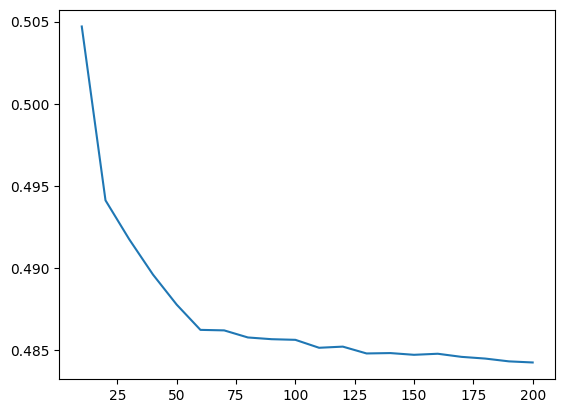

In [71]:
plt.plot(df_rmse.n_estimators, df_rmse.rmse)

# Question 4

In [72]:
depths = [10, 15, 20, 25]
estimator_steps = range(10, 201, 10)
num_estimators = len(list(estimator_steps))
rmse = []

for d in depths:
    total_rmse = 0
    for n in estimator_steps:
        rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        val_rmse = calculate_rmse(y_val, y_pred)
        total_rmse += val_rmse
    mean_rmse = total_rmse / num_estimators
    print(mean_rmse)
    rmse.append((d, n, mean_rmse))

df_rmse = pd.DataFrame(rmse, columns=['max_depth', 'n_estimators', 'rmse'])
df_rmse

0.49561582620114847
0.48379311662429425
0.4865844491352343
0.4867968024139584


,max_depth,n_estimators,rmse
0,10,200,0.495616
1,15,200,0.483793
2,20,200,0.486584
3,25,200,0.486797


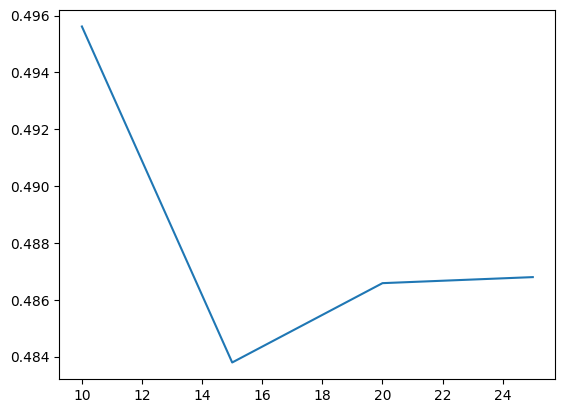

In [74]:
plt.plot(df_rmse.max_depth, df_rmse.rmse)

# Question 5

In [80]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rf.feature_importances_

array([0.04228931, 0.07157308, 0.33647774, 0.25285666, 0.10194623,
       0.01706754, 0.00852746, 0.06176456, 0.05029479, 0.05720262])

In [81]:
feats = {}
for feature, importance in zip(df_train.columns, rf.feature_importances_):
    feats[feature] = importance

feats

{'longitude': 0.042289309581645194,
 'latitude': 0.07157308261826283,
 'housing_median_age': 0.3364777379324447,
 'total_rooms': 0.2528566648564143,
 'total_bedrooms': 0.10194623011028803,
 'population': 0.017067540670828704,
 'households': 0.008527463478334857,
 'median_income': 0.06176455599756111,
 'ocean_proximity': 0.05029479372157965}

([0, 1, 2, 3],
 [Text(0, 0, 'total_rooms'),
  Text(1, 0, 'median_income'),
  Text(2, 0, 'total_bedrooms'),
  Text(3, 0, 'longitude')])

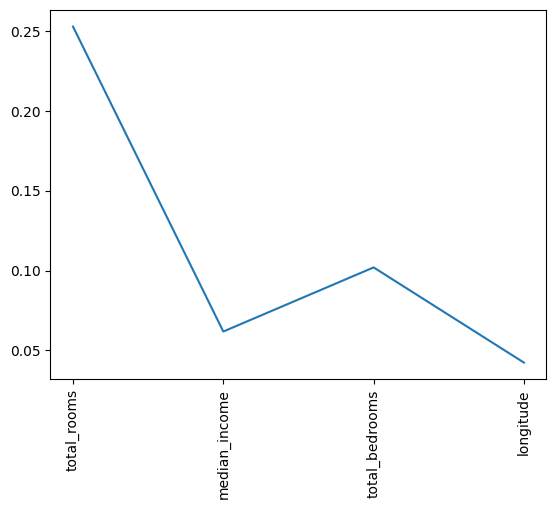

In [87]:
feat_subset = ['total_rooms', 'median_income', 'total_bedrooms', 'longitude']
feats_imp_subset = {k : feats[k] for k in feat_subset}
plt.plot(feats_imp_subset.keys(), feats_imp_subset.values())
plt.xticks(rotation='vertical')

# Question 6

In [101]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [102]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out().tolist()
features = [f.replace('<', '') for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [104]:
df_rmse = parse_xgb_output(output)
df_rmse.head()

,num_iter,train_rmse,val_rmse
0,0,0.60003,0.60622
1,5,0.51068,0.53632
2,10,0.47840,0.52102
3,15,0.46271,0.51767
4,20,0.44696,0.51445


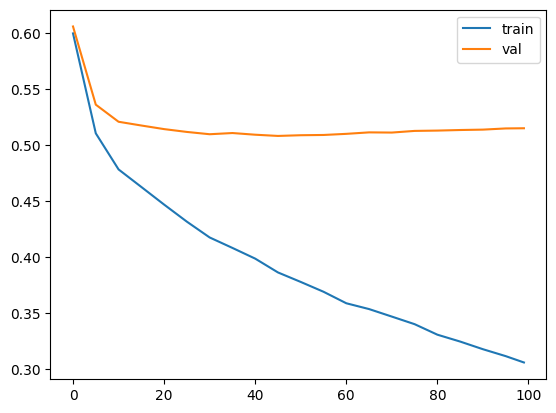

In [105]:
plt.plot(df_rmse.num_iter, df_rmse.train_rmse, label='train')
plt.plot(df_rmse.num_iter, df_rmse.val_rmse, label='val')
plt.legend()

In [108]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out().tolist()
features = [f.replace('<', '') for f in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [110]:
df_rmse = parse_xgb_output(output)
df_rmse.head()

,num_iter,train_rmse,val_rmse
0,0,0.63377,0.63795
1,5,0.57066,0.58091
2,10,0.53928,0.55513
3,15,0.51658,0.53775
4,20,0.50174,0.52838


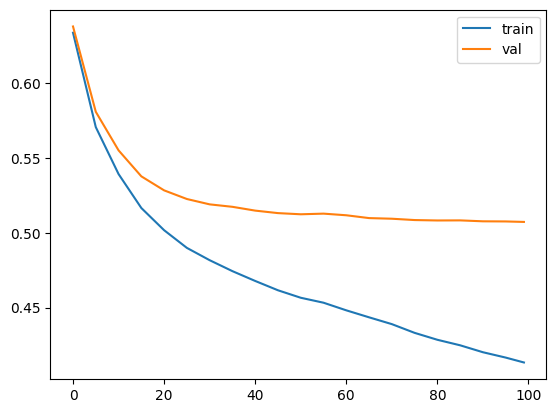

In [111]:
plt.plot(df_rmse.num_iter, df_rmse.train_rmse, label='train')
plt.plot(df_rmse.num_iter, df_rmse.val_rmse, label='val')
plt.legend()